In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from itertools import combinations

In [3]:
tickers = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0].Symbol.to_list()
timeframe = '5y'
start_cash = 10_000

In [8]:
df=yf.download(tickers[0], period=timeframe)

/var/folders/pc/lwrwx3mn1jq97mrd103w8tm80000gn/T/ipykernel_46266/3045763418.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df=yf.download(tickers[0], period=timeframe)
[*********************100%***********************]  1 of 1 completed


In [10]:
new_df = df.head()

In [ ]:
for i in new_df.iterrows():
    print(i)

TypeError: 'method' object is not iterable

In [5]:
def adftest(stock1, stock2, df):
    x = df[stock1].values
    x = sm.add_constant(x)
    y = df[stock2].values

    model = sm.OLS(y,x).fit()
    intercept, slope = model.params
    residuals = y - (intercept + slope*x[:,1])
    if np.isnan(residuals).any():
        return np.nan
    result = adfuller(residuals)
    return result[0], result[1], slope, intercept

In [ ]:
def test_coint (df = df):

    combination_df = pd.DataFrame(combinations(df.columns,2))
    combination_df.columns = ['Stock1','Stock2']
    combination_df['Correlation'] = combination_df.apply(lambda row: np.corrcoef(df[row['Stock1']],df[row['Stock2']])[0,1],axis=1)
    combination_df = combination_df[combination_df['Correlation'] > 0.95]
    combination_df[['adf_stat','p-value','Slope','Intercept']] = combination_df.apply(lambda row: pd.Series(adftest(row['Stock1'], row['Stock2'],df)),axis=1)
    combination_df = combination_df[combination_df['p-value'] < 0.05]
    return combination_df


In [12]:
print(test_coint())


       Stock1 Stock2  Correlation  adf_stat   p-value      Slope   Intercept
1048     ABBV    AZO     0.958215 -3.814832  0.002759  20.465938 -409.689246
1076     ABBV     CB     0.960987 -4.370219  0.000335   1.359728   23.011265
2708     ACGL    GWW     0.966569 -4.052641  0.001159  10.185384   32.316224
2725     ACGL   HUBB     0.962033 -4.238429  0.000567   3.866228   22.773596
2773     ACGL    LIN     0.968267 -3.402880  0.010861   3.138312  150.225047
...       ...    ...          ...       ...       ...        ...         ...
124849     TT    WAB     0.979589 -3.308512  0.014502   0.446031   16.644924
125478    URI    VMC     0.960472 -4.176830  0.000721   0.220805  100.469357
125651    VLO    XOM     0.965987 -3.238961  0.017837   0.777814    4.163036
125832    VST    WMT     0.971166 -3.240615  0.017751   0.347458   38.740733
126134    WMB    WRB     0.959565 -2.996796  0.035195   0.959464   12.429129

[559 rows x 7 columns]


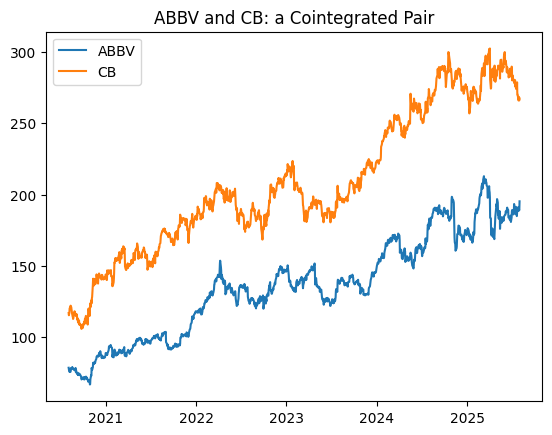

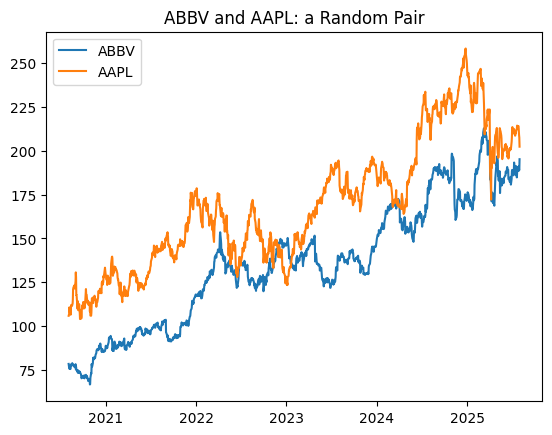

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
plt.title('ABBV and CB: a Cointegrated Pair')
ax.plot(df['ABBV'], label = 'ABBV')
ax.plot(df['CB'], label = 'CB')
ax.legend()


fig, ax = plt.subplots()
plt.title('ABBV and AAPL: a Random Pair')
ax.plot(df['ABBV'], label = 'ABBV')
ax.plot(df['AAPL'], label = 'AAPL')
ax.legend()


plt.show()


